In [1]:
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import glob
import astropy.units as u

from matplotlib.patches import Ellipse
from math import pi
from scipy import special
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import FlatLambdaCDM 

## Prb 1. Testing cosmology with supernovae

### 1 a)  Reproducing figure 5.1

In [2]:
data = np.loadtxt('../data/union-supernova-catalog.txt')
z = data[:,0]
DM = data[:,1]*u.mag
sigma = data[:,2]
n = len(z)

In [3]:
sort_z = np.sort(z)
modelDM_sort = cosmo.distmod(sort_z)

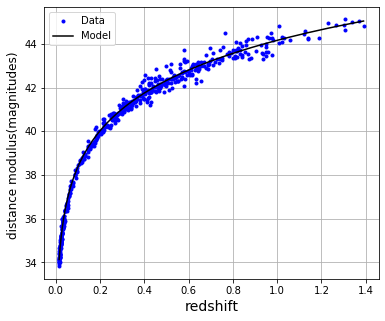

In [4]:
plt.figure(figsize=(6,5))
plt.plot(z, DM, '.b', markersize=6, label='Data')
plt.plot(sort_z, modelDM_sort, 'k', label='Model')
plt.xlabel('redshift', fontdict={'fontsize':14})
plt.ylabel('distance modulus(magnitudes) ', fontdict={'fontsize':12})
plt.grid(True, which='both')
plt.legend()

### 1 b) Computing p value

In [5]:
modelDM = cosmo.distmod(z)
residuals = (DM-modelDM) / sigma      # residuals in unit of sigma
dist = np.sum(residuals.value**2)

In [6]:
p_val = special.chdtrc(n, dist)

print('\n Calculated p value : %f' %p_val)


 Calculated p value : 0.141039


### This p value confirms what we see in the figure that data agreees with the Planck15 model reasonably.

### 1 c) We have considered two model. One of them overshoots and the other undershoots the data.

In [7]:
cos_over = FlatLambdaCDM(H0=65 * u.km / u.s / u.Mpc, Om0=0.1)
cos_under = FlatLambdaCDM(H0=78 * u.km / u.s / u.Mpc, Om0=0.4)

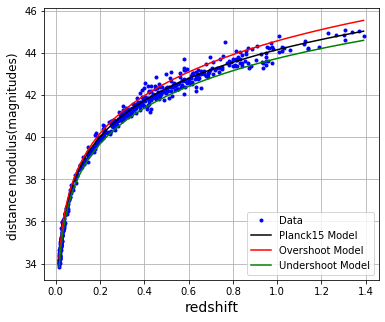

In [8]:
plt.figure(figsize=(6,5))
plt.plot(z, DM, '.b', markersize=6, label='Data')
plt.plot(sort_z, modelDM_sort, 'k', label='Planck15 Model')
plt.plot(sort_z, cos_over.distmod(sort_z), 'r', label='Overshoot Model')
plt.plot(sort_z, cos_under.distmod(sort_z), 'g', label='Undershoot Model')
plt.xlabel('redshift', fontdict={'fontsize':14})
plt.ylabel('distance modulus(magnitudes) ', fontdict={'fontsize':12})
plt.grid(True, which='both')
plt.legend()

### We can also check the p values for the overshoot and the undershoot model which we expect to show significant disagreement with the data.

In [9]:
DM_over = cos_over.distmod(z)
DM_under = cos_under.distmod(z)

In [10]:
dist_over = np.sum(((DM - DM_over) / sigma).value**2)
dist_under = np.sum(((DM - DM_under) / sigma).value**2)

In [11]:
print('\ncalculated p value for data with overshoot model : %e' %special.chdtrc(n, dist_over))
print('\ncalculated p value for data with undershoot model : %e' %special.chdtrc(n, dist_under))


calculated p value for data with overshoot model : 3.519994e-111

calculated p value for data with undershoot model : 1.420258e-169


## Prb 2. Covariance and correlation

### 2 a) Covariance matrix

In [12]:
gal_data = np.loadtxt('../data/hw5catalog1.txt')
x = gal_data[:, 0]
y = gal_data[:, 1]

In [13]:
mean_x = np.mean(x)
mean_y = np.mean(y)
N = gal_data.shape[0]

In [14]:
covariance = np.zeros((2,2))

cov_xx = np.sum((x- mean_x)**2) / (N-1)
cov_yy = np.sum((y- mean_y)**2) / (N-1)
cov_xy = np.sum((x- mean_x)*(y- mean_y)) / (N-1)

covariance[0][0] = cov_xx
covariance[1][1] = cov_yy
covariance[0][1] = cov_xy
covariance[1][0] = cov_xy

In [15]:
print(covariance)

[[0.15137835 0.4112953 ]
 [0.4112953  2.08820075]]


### Now we can check our result with the numpy covariance function.

In [16]:
np.cov(gal_data,rowvar=False)
#np.cov(gal_data.T)

array([[0.15137835, 0.4112953 ],
       [0.4112953 , 2.08820075]])

### 2b)  First calculate the one sigma length of semi-major and semi-minor axis and position angle of the semimajor axis using the eigenvalues of the covariance matrix

In [17]:
major_axis = np.sqrt(np.abs(0.5*(cov_xx + cov_yy + np.sqrt((cov_xx - cov_yy)**2 + 4*cov_xy**2))))
minor_axis = np.sqrt(np.abs(0.5*(cov_xx + cov_yy - np.sqrt((cov_xx - cov_yy)**2 + 4*cov_xy**2))))
angle = np.degrees(0.5*np.arctan2(2*cov_xy, cov_xx-cov_yy))
                  
myellipse = Ellipse(xy=[mean_x, mean_y], width=2*1.52*major_axis, height=2*1.52*minor_axis, 
                    angle=angle, fill=False)

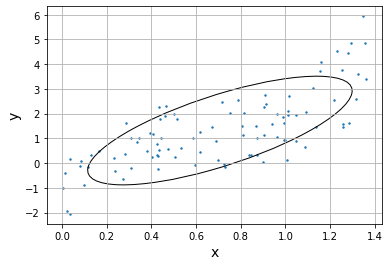

In [18]:
ax = plt.subplot(111)
ax.scatter(x, y, s=2)
ax.set_xlabel('x', fontdict={'fontsize':14})
ax.set_ylabel('y', fontdict={'fontsize':14})
ax.add_artist(myellipse)
plt.grid(True, which='both')

 ### 2 c) First we calculate r using the data and then check it with the scipy pearsonr function.

In [19]:
r = (N-1)*cov_xy / (np.sqrt(np.sum((x-mean_x)**2))* np.sqrt(np.sum((y-mean_y)**2)))
r1 = sp.pearsonr(x,y)[0]
print('\ncalculated r : %f' %r)
print('\ncalculated r using pearsonr function : %f' %r1)


calculated r : 0.731536

calculated r using pearsonr function : 0.731536


###  2 d) Spearman rank-correlation test

In [20]:
rank_corr = sp.spearmanr(x,y)
print('\nSpearman r : %f' %rank_corr[0])
print('\nSpearman p-value : %e' %rank_corr[1])


Spearman r : 0.715600

Spearman p-value : 2.556295e-16


###  The p value indicates high significance as it suggests that two uncorrelated dataset similar as the ones we have used here having the same r value as this is highly unlikely. 

### Correlating the ranks or Spearman test doesn't assume a liner relation and  normal distribution of the data set which are useful to work with datasets which don't have any linear relation and don't have a normal distribution. This test doesn't work well for dataset with linear relation.

## Prb 3. Testing significance of correlations

### 3 a) Pearson r

In [21]:
gal_data1 = np.loadtxt('../data/hw5catalog2.txt')
x1 = gal_data[:, 0]
y1 = gal_data[:, 1]

In [22]:
mean_x1 = np.mean(x1)
mean_y1 = np.mean(y1)
N1 = gal_data1.shape[0]

In [23]:
r = np.sum((x1- mean_x1)*(y1- mean_y1))/ (np.sqrt(np.sum((x1-mean_x1)**2))* np.sqrt(np.sum((y1-mean_y1)**2)))
r1 = sp.pearsonr(x1,y1)
print('\ncalculated r : %f' %r)
print('\ncalculated r using pearsonr function : %f' %r1[0])


calculated r : 0.731536

calculated r using pearsonr function : 0.731536


### 3b) Under the null hypothesis the uncorrelated r should come from of a normal distribution such that N(0, 1/n) where n is the sample number. Using the survival function for this normal distribution we can calculate the one sided p value for our pearson r value. 

In [24]:
sp.norm.sf(r, loc=0, scale=1/N1)

3.3436094308291814e-293

###  This p-value suggests that the calculated  r value coming from the normal distribution under the null hypothesis is highly unlikely.

### 3 c) Second significance check

### To convert the two sided p value to a one sided one we need to divide the two sided p value with two if there is symmerty in the distribution under the null hypothesis.

In [25]:
print('\nPearson two sided p-value : %e' %r1[1])
print('\nPearson one sided p-value : %e' %(r1[1]/2))


Pearson two sided p-value : 2.570754e-17

Pearson one sided p-value : 1.285377e-17


### 3d) Third significance check

In [26]:
r_values = np.zeros(5000)
for i in range(5000):
    shuffled_y = np.random.permutation(y1)
    r_values[i] = sp.pearsonr(x1, shuffled_y)[0]

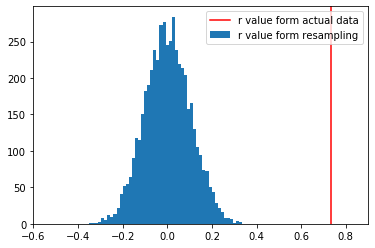

In [27]:
bins = plt.hist(r_values, bins=50, label='r value form resampling')
plt.axvline(r1[0], color='r', label='r value form actual data')
plt.xlim(-0.6, 0.9)
plt.legend()

### 3 e)

In [28]:
def p_val(dist, val):
    """
    This function calculates the p-value, given a 
    distribution and the value for which p-value 
    to be calculated. The calculated p-value will
    be more accurate if the sample size is very big.
    """
    
    sorteddist = np.sort(dist)
    fractiongrid = np.linspace(0,1,len(dist)+1)
    
    #m = np.ones(len(sorteddist), dtype=bool)
    
    m = sorteddist >= val
    
    p = (1*m).sum() / len(dist)
    
    #print(sorteddist)
    #print(fractiongrid)
    #print(m)
    #print(ind)
    print('\np value : %e' %p)  #%round(p, 8)
    
    return p

In [29]:
p_val(r_values, r1[0])


p value : 0.000000e+00


0.0

### 3 e) On way to report the uncertainty is to use a confidence interval. A broader confidence interval denotes higher uncertainty. Similarly a lower confidence interval denotes lower uncertainty. We can calculate a confidence interval via resampling. Using bootstarp resampling method we can have many realizations of the data set and calculate r for each realization. Then we can find out where our actual r value resides within this distribution of r.  We can calculate what percentage of r values lie withing certain range centring our actual r value. This percentage is our confidence interval. We can quote this percentange with the range as a manifestation of uncertainty. 

## Prb 4.

### 4 a) Fisher method to combine independent p values

In [30]:
def fisher_p(p_list):
    '''
    This function calculates a combined p value
    from the list of given independent p values
    using Fisher method.
    '''
    
    x = -2*np.sum(np.log(np.asarray(p_list)))
    k = 2*len(p_list)
    comb_p = special.chdtrc(k, x)
    
    return comb_p

### 4 b) I have checked the fisher method using three test case. In the first one we assume that the null hypothesis has been tested with three independent data set and been confirmed with three independent p values. The p values  are 0.5, 0.2 and 0.3. If we just multiply them we get 0.03 which will mean the combined p value is rejecting the null hypothesis. However the combined p value should also confirm the null hypothesis as its independent counterparts. Using Fisher method the calculated combined p value is 0.32. That means the combined p value also not rejecting the null hypothesis as expected.  

In [31]:
fisher_p([0.5, 0.20, 0.3])

0.31963596122845644

###  In the second case I assumed again a null hypothesis being tested with three different data set. But this time only two data set confirms the null hypothesis while the thrird one rejects it. The p values are 0.1, 0.2 and 0.03. If we just multiply these p values we get 0.0006 which means the combined p value is rejecting the null hypothesis with very high statistical significance. Now this interpretation doesn't go well with the independent tests. However using Fisher method the combined p value is found as 0.02. This p value says there is certain amount of tension between data and null hypothsis but does not reject it completely which I guess more align with the results from the independent tests. 

In [32]:
fisher_p([0.03, 0.1, 0.2])

0.021561751324834642

### 4 c) 

In [33]:
xray_p = [0.004,0.002, 0.002]   ##reported p values in the second row

print('\nCorrect p-value to report using Fisher method : %f' %fisher_p(xray_p))


Correct p-value to report using Fisher method : 0.000003


In [34]:
dynamic_p = [0.184, 0.07, 0.47]  ##reported p values in the third row

print('\nCorrect p-value to report using Fisher method : %f' %fisher_p(dynamic_p))


Correct p-value to report using Fisher method : 0.115916


### For both rows the difference in numerical values between the reported ones and calculated ones here using Fisher method are a lot. However still for the second row the reported one could be considered as not such a big mistake as both the reported and calculated p values reject the null hypothesis with very high significance.  On the other hand the reported p value in thrid row could be considered as a huge mistake as the calculated p value interprets the results from the data sets completely differently. 

### 4 d) Under the null hypothesis p values are uniformly distributed within 0 to 1. Any set of two, three or more numbers randomly chosen from this distribution will result in a lower number than the individual ones in the set if the numbers in the set are mutliplied. That means if we just multiply p values we will always end up with a lower p value than the factors. Another possible way to look at it is the p values indicates how different the data is than the assumed model or hypothesis. When we combine the independent p values the differnces add up not get multiplied. Then we can check again what is the total difference from the combined data samples and interpret the significance of this difference accordingly. However when we are multiplying the p values, we are in this context multiplying the differences and of course that will result in huge difference for the combined data samples.  